In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

Regression models predict a continuous variable, such as the sales made on a day or predict temperature of a city.

Their reliance on a polynomial (like a straight line) to fit a dataset possesses a real challenge when it comes towards building a classification capability.

Let’s imagine that you fit a line with the training points you have. Imagine you want to add another data point, but to fit it, you need to change your existing model (maybe the threshold itself, as well). This will happen with each data point that we add to the model; hence, linear regression isn’t good for classification models.

In [2]:
#### 
# Pandas df with companies properties
####

mean = np.array([0.001, 0.00132, 0.00127, 0.0019, 0.0011])

# cov = np.array([[0.1, 0.06 , 0.03, 0.08, 0.09],
#        [0.06, 0.002 , 0.01, 0.001, 0.01],
#        [0.03, 0.01 , 0.003, 0.01, 0.02],
#        [0.08, 0.001, 0.01, 0.04, 0.01],
#        [0.09 , 0.01  , 0.02, 0.001, 0.005]])
std = np.array([0.0005, 0.00032, 0.0007, 0.0006, 0.0002])
cov = np.outer(std, std)

returns = np.random.multivariate_normal(mean, cov, 1000)
returns += np.random.normal(0, .01, size=returns.shape)

df = pd.DataFrame(returns, columns = ['aapl', 'msft', 'goog', 'amzn', 'sap'])

df1 = df.add(1).cumprod().add(-1)
df1.tail()

,aapl,msft,goog,amzn,sap
995,1.640160,2.435075,2.183380,3.356121,3.919845
996,1.642008,2.442520,2.227680,3.390009,3.900156
997,1.694121,2.439535,2.226653,3.359006,3.886413
998,1.729201,2.470166,2.220493,3.407471,3.885171
999,1.764080,2.448964,2.253211,3.447415,3.827761


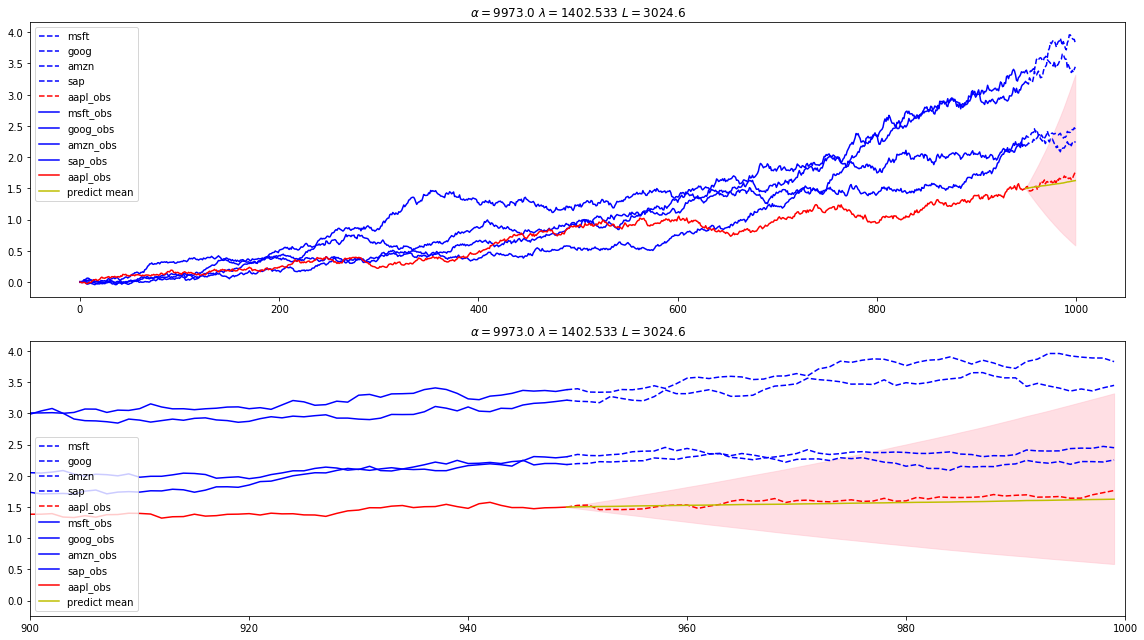

In [18]:
n_order = 3
X, y = df.drop('aapl', axis=1), df['aapl']
train_length = 950
X_train, X_test = X.iloc[:train_length], X.iloc[train_length:]
y_train, y_test = y.iloc[:train_length], y.iloc[train_length:] # train_test_split(X, y, test_size=0.2)

reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
reg.set_params(alpha_init=1., lambda_init=1e-3)
reg.fit(X_train, y_train)
ymean, ystd = reg.predict(X_test, return_std=True)

X_test_cmpd = pd.concat([X_train, X_test]).add(1).cumprod().add(-1).iloc[train_length-1:]
y_test_cmpd = pd.concat([y_train, y_test]).add(1).cumprod().add(-1).iloc[train_length-1:]
X_train_cmpd = X_train.add(1).cumprod().add(-1)
y_train_cmpd = y_train.add(1).cumprod().add(-1)

ymean_cmpd = pd.concat([y_train, pd.Series(ymean)], ignore_index=True).add(1).cumprod().add(-1).iloc[train_length-1:]
ymean_cmpd_p = pd.concat([y_train, pd.Series(ymean+ystd)], ignore_index=True).add(1).cumprod().add(-1).iloc[train_length-1:]
ymean_cmpd_m = pd.concat([y_train, pd.Series(ymean-ystd)], ignore_index=True).add(1).cumprod().add(-1).iloc[train_length-1:]

# Plot
plt.figure(figsize=(16, 9))

# All data
plt.subplot(2, 1, 1)

plt.plot(X_test_cmpd, color="blue", linestyle='--')
plt.plot(y_test_cmpd, color="red",  linestyle='--')
plt.plot(X_train_cmpd, color="blue")
plt.plot(y_train_cmpd, color="red")
plt.plot(X_test_cmpd.index, ymean_cmpd, color="y")
plt.fill_between(ymean_cmpd_m.index, ymean_cmpd_m, ymean_cmpd_p, color="pink", alpha=0.5)
plt.legend(X_test_cmpd.columns.tolist() + [y.name + '_obs'] + (X.columns + '_obs').tolist() + [y.name + '_obs'] + ['predict mean'])
text = "$\\alpha={:.1f}$ $\\lambda={:.3f}$ $L={:.1f}$".format(reg.alpha_, reg.lambda_, reg.scores_[-1])
plt.title(text, fontsize=12)


# Zoom in
plt.subplot(2, 1, 2)

plt.plot(X_test_cmpd, color="blue", linestyle='--')
plt.plot(y_test_cmpd, color="red",  linestyle='--')
plt.plot(X_train_cmpd, color="blue")
plt.plot(y_train_cmpd, color="red")
plt.plot(X_test_cmpd.index, ymean_cmpd, color="y")
plt.fill_between(ymean_cmpd_m.index, ymean_cmpd_m, ymean_cmpd_p, color="pink", alpha=0.5)
plt.legend(X_test_cmpd.columns.tolist() + [y.name + '_obs'] + (X.columns + '_obs').tolist() + [y.name + '_obs'] + ['predict mean'])
text = "$\\alpha={:.1f}$ $\\lambda={:.3f}$ $L={:.1f}$".format(reg.alpha_, reg.lambda_, reg.scores_[-1])
plt.title(text, fontsize=12)

plt.xlim([900,1000])

plt.tight_layout()
plt.show()

## Try more regressions

Define plot helper

In [46]:
def plot_data(X_test_cmpd, y_test_cmpd, X_train_cmpd, y_train_cmpd, y_pred_cmpd, *args, **kwargs):
    
    def _plot_data(X_test_cmpd, y_test_cmpd, X_train_cmpd, y_train_cmpd, y_pred_cmpd, *args, **kwargs):
        plt.plot(X_test_cmpd, color="blue", linestyle='--')
        plt.plot(y_test_cmpd, color="red",  linestyle='--')
        plt.plot(X_train_cmpd, color="blue")
        plt.plot(y_train_cmpd, color="red")
        plt.plot(y_test_cmpd.index, y_pred_cmpd, color="y")
        plt.legend((X_test_cmpd.columns+'_test').tolist() + [y_test_cmpd.name + '_test'] + (X_train_cmpd.columns + '_obs').tolist() + [y_train_cmpd.name + '_obs'] + ['prediction'])
        title = kwargs.get('title')
        plt.title(f'{type(reg).__name__} {title}')

    # Plot
    plt.figure(figsize=(16, 9))

    # All data
    plt.subplot(2, 1, 1)
    _plot_data(X_test_cmpd, y_test_cmpd, X_train_cmpd, y_train_cmpd, y_pred_cmpd, *args, **kwargs)

    # Zoom in
    plt.subplot(2, 1, 2)
    _plot_data(X_test_cmpd, y_test_cmpd, X_train_cmpd, y_train_cmpd, y_pred_cmpd, *args, **kwargs)
    plt.xlim([900,1000])

    plt.tight_layout()
    plt.show()

Plot some regressions

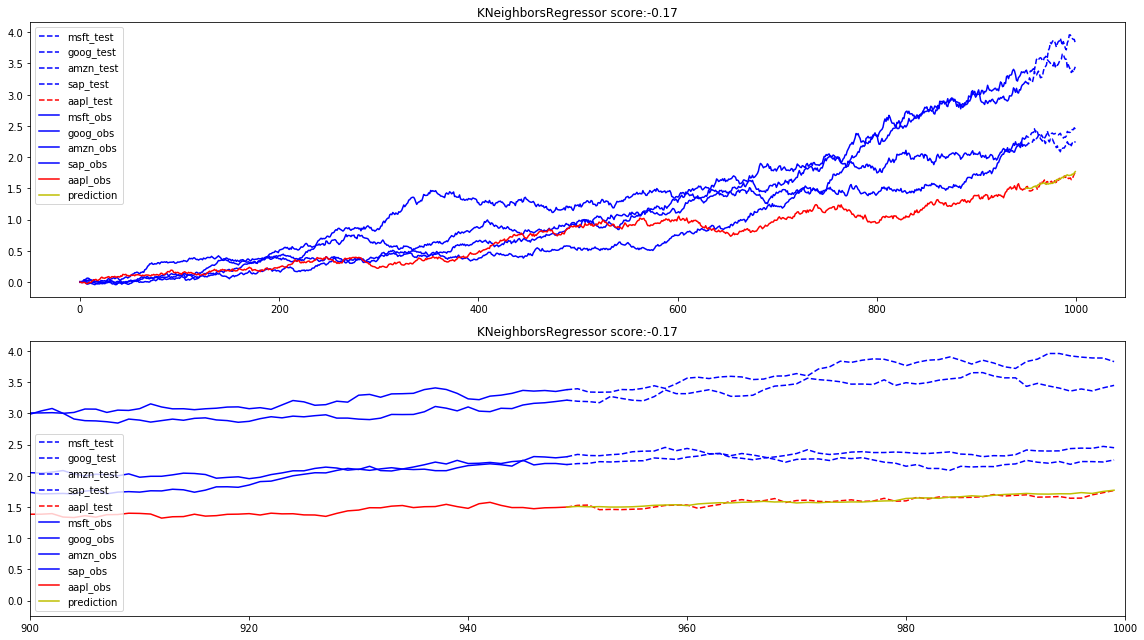

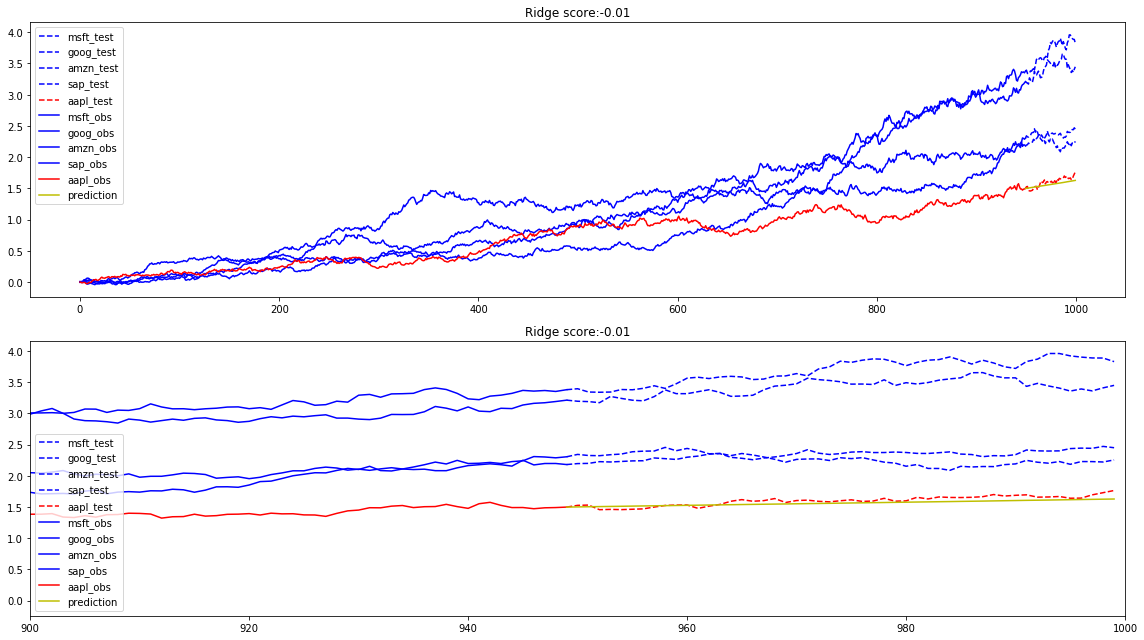

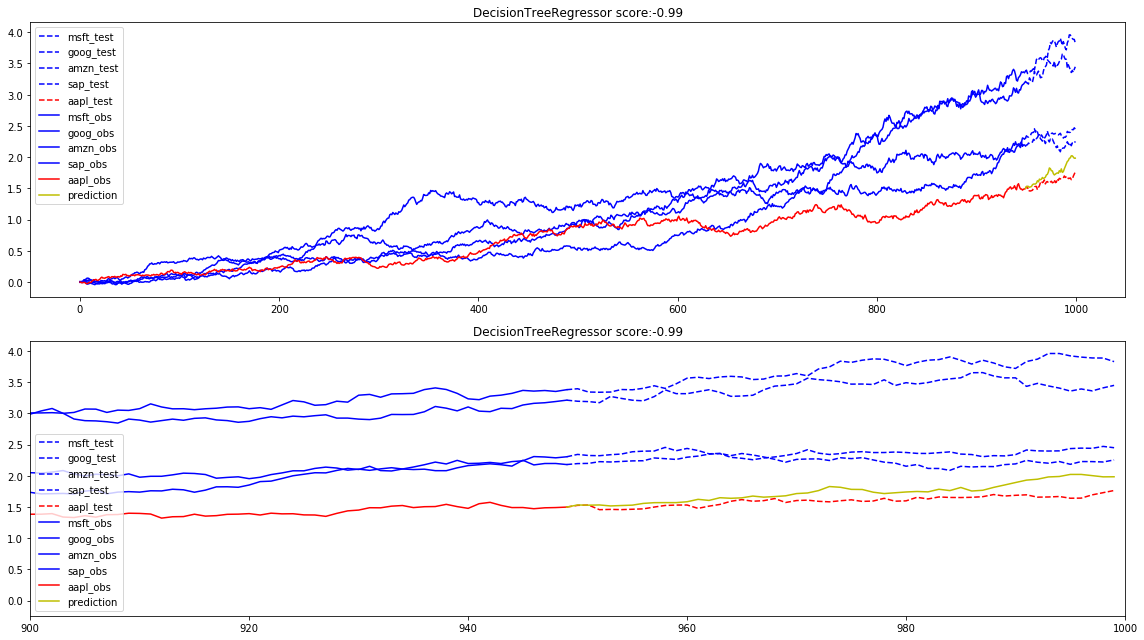

In [51]:
X_test_cmpd = pd.concat([X_train, X_test]).add(1).cumprod().add(-1).iloc[train_length-1:]
y_test_cmpd = pd.concat([y_train, y_test]).add(1).cumprod().add(-1).iloc[train_length-1:]
X_train_cmpd = X_train.add(1).cumprod().add(-1)
y_train_cmpd = y_train.add(1).cumprod().add(-1)

regs = [KNeighborsRegressor(), Ridge(), DecisionTreeRegressor()]

for reg in regs:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    y_pred_cmpd = pd.concat([y_train, pd.Series(y_pred)], ignore_index=True).add(1).cumprod().add(-1).iloc[train_length-1:]

    plot_data(X_test_cmpd, y_test_cmpd, X_train_cmpd, y_train_cmpd, y_pred_cmpd, title=f'score:{reg.score(X_test, y_test):.2f}')